# Nonlinear Elasticity in a multipatch domain


In [40]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

Populating the interactive namespace from numpy and matplotlib


/home/hilbert/heigl/anaconda/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['solve', 'bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [41]:
p = 3  # spline degree 
n_el = (40,15)  #(40,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
multi= 1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [42]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 0.4
r_in = 0.31

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

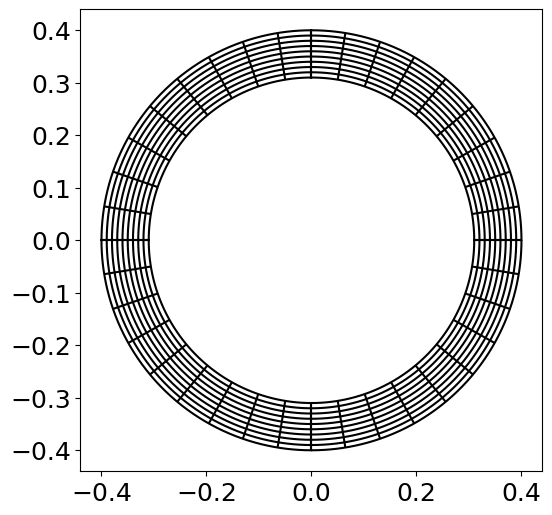

In [43]:
figsize(8,6)
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [44]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [45]:
# source term f 
def f(x, y): return (0.0, 0.0)

In [46]:
#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*loading_value, y/r_in*loading_value)  #inner  pressure, normalized vector


#incremental loading
#loading = [1e-4, 1.5e-4, 2e-4, 2.5e-4, 3e-4]
#loading = [5e-5, 8e-5, 1e-4, 1.25e-4]# 1.5e-4]
loading = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 1.25e-4] #,1.5e-4 ]

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]
#loading_value = loading[0]
# set Neumann data
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 


In [47]:
# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [48]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ), 
])

In [49]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = n_el[1] # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
   
    figsize(7,7)
    fig, ax = plt.subplots()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
    colorbar();
    axis('equal')


In [50]:
# Compute solution of nonlinear elasticity problem

In [51]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [52]:
def get_components_u(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    return np.stack((u1,u2), axis=-1)

In [53]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0


# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A



In [54]:
def rotate_normal(nv): # rotate
    nv_rot= []
    nx= nv[..., 0]
    ny= nv[..., 1]
    nv_rot= np.stack((ny,-nx), axis=-1)
    return nv_rot
    

In [55]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u, neu_data):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        
        uu = get_components_u(X.T @ u, kvs_ux)

        # The patch-local Neumann boundary data 
        for item in neu_data:
            if item[0]==p:
                #N_e = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1]) #first attempt 
            ## implemented normal vector
                nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                #print(nv.sum(axis=(0,1)))
                nv_r = rotate_normal(nv)
                #print('adapted normal:', nv - rotate_normal(uu*nv_r))
                n_tilde = nv- rotate_normal(uu * nv_r)
                N_adapted = -n_tilde*loading_value
                print('N_adapted', np.linalg.norm(N_adapted))
                
                # normal vector with loading
                N_en = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= -loading_value
                print('N_en', np.linalg.norm(N_en))
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        #b_p[bdofs[i]+offset] += N_e[c, i, 0] # first attempt
                        b_p[bdofs[i]+offset] += N_en[i, 0, c] # (43,1,2)
                        

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [56]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    # a(u,v)-l(v)
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        uu = get_components_u(X.T @ u, kvs_ux)

        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)

        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                # normal vector with loading
                #nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                #nv_r = rotate_normal(nv)
                #n_tilde = nv - rotate_normal(uu * nv_r)
                #N_en = -n_tilde*loading_value ## adapted normal
                
                #N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1]) # first attempt
                
                N_en = -assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= loading_value
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        #b0_p[bdofs[i]+offset] += N_e[c, i, 0] # first attempt
                        b0_p[bdofs[i]+offset] += N_en[i, 0, c]
                        
                        
        if first:
            grad_b = X @ (b_p- b0_p)
            first = False
        else:
            grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

def J(x): #energy functional
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [57]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha

      

In [58]:
def make_solver_chol(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
   

In [59]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [60]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [61]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
solution = []

#initial value
u= np.zeros(dd)

#set Neumann boundary force (via incremental loading) 
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
### first iteration ###
A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_chol(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
solution.append(u)
#solutions = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

N_adapted 4.0336120849664173e-05
N_en 9.50731485985254e-06
N_adapted 4.033612084966418e-05
N_en 9.50731485985254e-06
N_adapted 4.033612084966418e-05
N_en 9.50731485985254e-06
N_adapted 4.033612084966418e-05
N_en 9.50731485985254e-06
r0= 1.9039432212997212e-05
use SuperLU
N_adapted 4.0700222321039406e-05
N_en 9.50731485985254e-06
N_adapted 4.033617770044305e-05
N_en 9.50731485985254e-06
N_adapted 3.997686559905038e-05
N_en 9.50731485985254e-06
N_adapted 4.034555108904839e-05
N_en 9.50731485985254e-06
residual =  3.6509092906087055e-06


In [62]:
solution

[array([0.00354575, 0.00349951, 0.00341149, ..., 0.00984092, 0.00984213,
        0.00984286])]

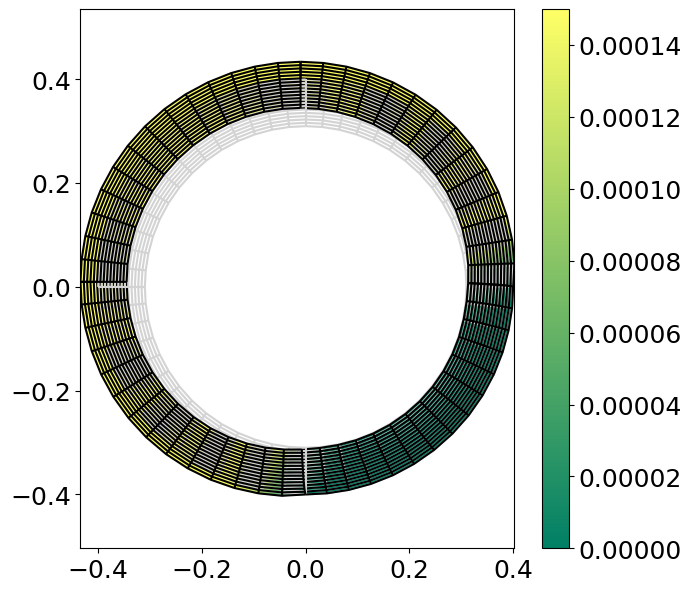

In [63]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

N_adapted 1.6134448339865662e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
r0= 7.615772885198886e-06
use SuperLU
N_adapted 1.619247487024478e-05
N_en 3.8029259439410157e-06
N_adapted 1.613445197831767e-05
N_en 3.8029259439410157e-06
N_adapted 1.6076731954493398e-05
N_en 3.8029259439410157e-06
N_adapted 1.6135051934446487e-05
N_en 3.8029259439410157e-06
residual =  5.87283514675677e-07


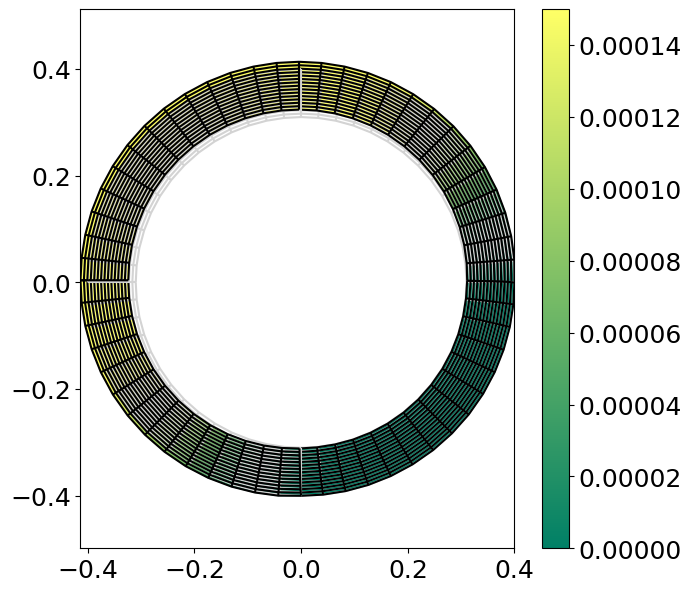

In [64]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
solution = []

#initial value
u= np.zeros(dd)

loading_value = loading[0] # choose smallest loading
#set Neumann boundary force (via incremental loading) 
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
### first iteration ###
A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_chol(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
solution.append(u)
#solutions = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

get_defplot(u, patches_u, kvs_u)

In [65]:
solution

[array([0.0014183 , 0.0013998 , 0.0013646 , ..., 0.00393637, 0.00393685,
        0.00393714])]

 
 
 1. loading: 5e-05 

u=  [0. 0. 0. ... 0. 0. 0.]
1
N_adapted 1.6134448339865662e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
N_adapted 1.6134448339865665e-05
N_en 3.8029259439410157e-06
use SuperLU
8.060619089429549e-07
Start line search
  0. alpha between 0 and None
alpha= 1
N_adapted 1.619247487024478e-05
N_en 3.8029259439410157e-06
N_adapted 1.613445197831767e-05
N_en 3.8029259439410157e-06
N_adapted 1.6076731954493398e-05
N_en 3.8029259439410157e-06
N_adapted 1.6135051934446487e-05
N_en 3.8029259439410157e-06
residual =  5.87283514675677e-07
2
N_adapted 1.619247487024478e-05
N_en 3.8029259439410157e-06
N_adapted 1.613445197831767e-05
N_en 3.8029259439410157e-06
N_adapted 1.6076731954493398e-05
N_en 3.8029259439410157e-06
N_adapted 1.6135051934446487e-05
N_en 3.8029259439410157e-06
use SuperLU
9.131764471186936e-10
Start line search
  0. alpha between 0 and None
alpha= 1


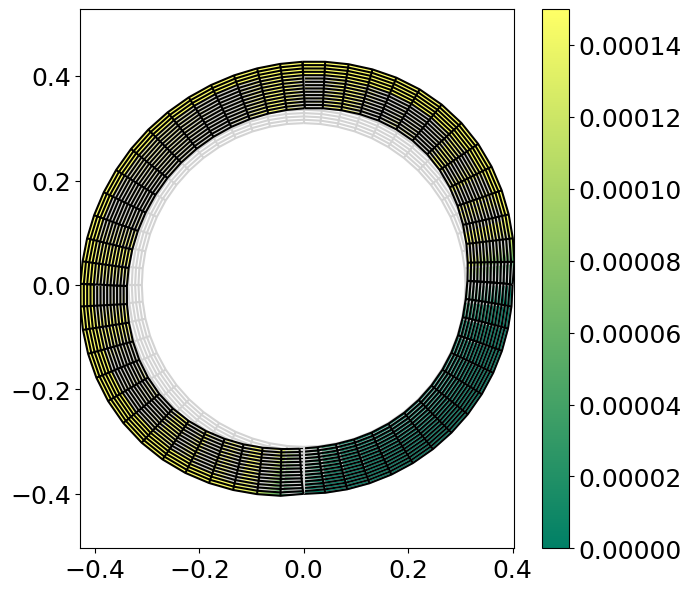

In [66]:
# solve linearized variational problem

#initial value
u= np.zeros(dd)

epsilon= 1e-3 #1e-6

stepsizes = [] 
ud_array = []
solutions = []

# incremental loading # ----------------------------------
for i in range(len(loading)):
    print(" \n \n {}. loading: {} \n".format(i+1,loading[i]))
    
    # set Neumann data via incremental loading
    loading_value = loading[i]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # inner radius
    print('u= ', u)
    
    count= 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, b= ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_chol(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        if LS.b.dot(u_d) <= 0:
            print(LS.b.dot(u_d)) #transpose(LS.b)*M*LS.b
            print('Matrix is not positive definit! \n')
        else:
            print(LS.b.dot(u_d))

        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        if alpha == None:
            u += 0.5 * u_d # alpha=0.5 (ignore line search)
        else:
            u += alpha * u_d

        # compute new non-linear residuum
        A, b = ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)
        
        #----------------------------------------------------#
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        normed_du0 = normed_du
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition
            break
        elif count == 30:
            break
    
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    
# print deformation plot
get_defplot(u, patches_u, kvs_u)

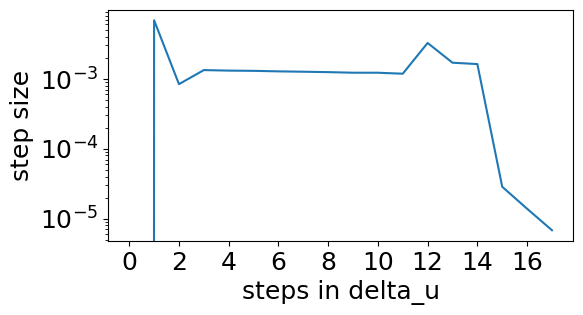

In [67]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [68]:
solutions

[array([0.00144522, 0.00142647, 0.00139094, ..., 0.00339442, 0.00341168,
        0.00342044]),
 array([0.00174227, 0.00171969, 0.00167697, ..., 0.00389062, 0.0039163 ,
        0.00392931]),
 array([0.00204317, 0.00201673, 0.00196679, ..., 0.00429912, 0.00433546,
        0.00435385]),
 array([0.00234875, 0.00231843, 0.00226122, ..., 0.00458412, 0.00463398,
        0.00465919]),
 array([0.00266036, 0.0026261 , 0.00256158, ..., 0.00469794, 0.00476506,
        0.00479896]),
 array([0.00298006, 0.00294182, 0.00286993, ..., 0.00456225, 0.00465174,
        0.00469688]),
 array([0.00384399, 0.00379536, 0.00370466, ..., 0.00190616, 0.00209357,
        0.00218785])]

In [69]:
s_sol= shape(solutions)[0]

In [70]:
s_sol

7

In [71]:
import matplotlib
import matplotlib.pyplot as plt

def plot_annulus(u, kvs_u, patches_u,vrange=None, res=(50,50), **kwargs):
    kwargs.setdefault('shading', 'gouraud')
    #fig, ax = plt.subplots(figsize=(5,5))
    #fig, ax = plt.subplots(figsize=(8,8))
    #ax.set_aspect('equal')
    u = LS.complete(u)
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
                for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
                for p in range(len(patches_u))]

    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
        plt.pcolormesh(XY[..., 0] + dis[..., 0], XY[..., 1] + dis[..., 1], C, shading='gouraud', cmap='summer', 
                                    vmin=vrange[0], vmax=vrange[1])
    

        

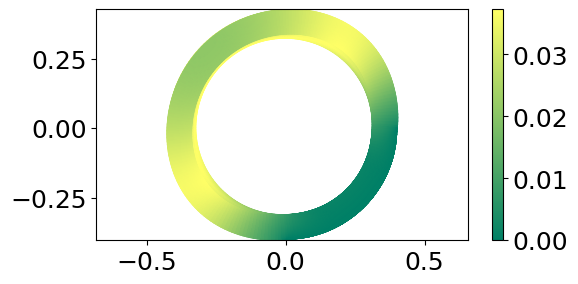

In [72]:
for i in range(s_sol):
    plot_annulus(solutions[i], kvs_u, patches_u)

plt.axis("equal")    
colorbar();

In [73]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field(fields, patches_u, kvs_u, vrange=None, res=(50,50),cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    fields = list(fields)
    
    figsize(7,7)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(left=0, right=1.5)
    ax.set_ylim(bottom=-0.5, top=0.5)
    
    
    ar= np.linspace(1,3, s_sol)
    factor = ar[0]

    if np.isscalar(res):
        res = (res, res)

    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs::]
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
        #vis.plot_grid(XY[..., 0] + dis[..., 0], XY[..., 1] + dis[..., 1], ax=ax, color="black")
        quadmesh = plt.pcolormesh(XY[..., 0] + factor* dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='summer',
                                    vmin=vrange[0], vmax=vrange[1], axes=ax)
        
   
    fig.colorbar(quadmesh, ax=ax);
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    
    def anim_func(i):
        plt.cla()
        #factor = ar[i] # choose factor for deformation plot
        u = LS.complete(fields[i])
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:]
        
        vrange= None

    # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]

    # visualization per patch
        for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
            grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
            XY = geo.grid_eval(grd)
            dis1 = u1_func.grid_eval(grd) #x-value
            dis2 = u2_func.grid_eval(grd) #y-value
            dis = np.stack((dis1,dis2), axis=-1)
            C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
            if vrange is None:
                vrange = (C.min(), C.max())
            quadmesh = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='summer', 
                                      vmin=vrange[0], vmax=vrange[1], axes=ax)
        
        quadmesh.set_array(C.ravel())
        pbar.update()
        if i == len(u) - 1:
            pbar.close()
  
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)


8it [00:01,  4.16it/s]                                                                                                                                                                                                                      


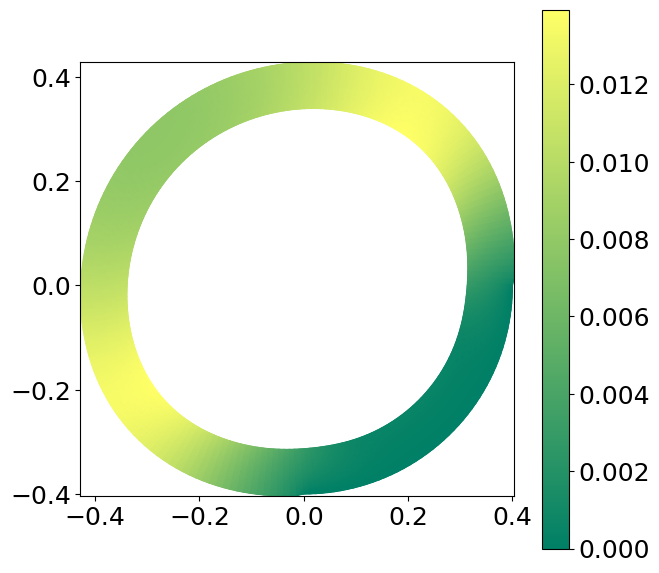

In [74]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)]
HTML(animate_field(fields, patches_u, kvs_u, res=(50,70), interval=335, progress=True).to_html5_video())

In [75]:
plt.clf()

<Figure size 700x700 with 0 Axes>

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,3, s_sol)
factor = 1


#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    u = LS.complete(fields[tt])
    #factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='summer', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
#ani.save("rtest.mp4", writer=writer )
vid = ani.to_html5_video()

plt.close()



In [77]:
ani

In [78]:
#vid